# import

In [78]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time,datetime
import variable_bin_methods as varbin_meth
import variable_encode as var_encode
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,confusion_matrix,recall_score,precision_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from feature_selector import FeatureSelector
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import missingno as msno
import matplotlib
#matplotlib.use(arg='Qt5Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams['font.sans-serif']=['SimHei']   
matplotlib.rcParams['axes.unicode_minus']=False  
#from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore") ##忽略警告

%matplotlib inline

# 函数定义

In [79]:
######子函数
##删除缺失值多的样本
def del_na(df,colname_1,rate):
    ##df: dataframe
    ##colname_1: 列名list
    ##rate:缺失值比例，大于rate变量删除
    na_cols = df[colname_1].isna().sum().sort_values(ascending=False)/float(df.shape[0])
    na_del = na_cols[na_cols >= rate]
    print ('\n'.join(["变量缺失值多,该变量被删除 {} ".format(i) for i in na_del.index]))
    df = df.drop(na_del.index, axis=1)
    return df,na_del
##目标变量映射字典
def target_mapping(lst):
    ##Late (31-120 days)、Default、Charged Off映射为1，坏样本
    ##Late (16-30 days)、In Grace Period映射为2,不确定样本
    ##Current、Fully Paid映射为0，好样本
    mapping = {}
    for elem in lst:
        if elem in ["Charged Off",'Late (16-30 days)', "Late (31-120 days)" ]:
            mapping[elem] = 1
        elif elem in ['In Grace Period']:
            mapping[elem] = 2
        elif elem in ['Current','Fully Paid']:
            mapping[elem] = 0
        else:
            mapping[elem] = 3
    return mapping   
# 删除常量
def constant_del(df, cols):
    dele_list = []
    for col in cols:
        # remove repeat value counts
        uniq_vals = list(df[col].unique())
        if pd.isnull(uniq_vals).any():
            if len( uniq_vals ) == 2:
                dele_list.append(col)
                print ("变量只有一种取值,该变量被删除 {} ".format(col))
        elif len(df[col].unique()) == 1:
            dele_list.append(col)  
            print ("变量只有一种取值,该变量被删除 {} ".format(col))
    df = df.drop(dele_list, axis=1)
    return df,dele_list
##删除长尾数据
def tail_del(df,cols,rate):
    dele_list = []
    len_1 = df.shape[0]
    for col in cols:
        if len(df[col].unique()) < 5:
            if df[col].value_counts().max()/len_1 >= rate:
                dele_list.append(col)  
                print ("变量分布不均衡,该变量被删除 {} ".format(col))
    df = df.drop(dele_list, axis=1)
    return df,dele_list
##时间格式转化      
def trans_format(time_string, from_format, to_format='%Y.%m.%d'):
    ##from_format:原字符串的时间格式
    ##param to_format:转化后的时间格式
    if pd.isnull(time_string):
        return np.nan
    else:
        time_struct = time.strptime(time_string,from_format)
        times = time.strftime(to_format, time_struct)
        times = datetime.datetime.strptime(times,'%Y-%m')
        return times  
##离散变量与连续变量区分   
def category_continue_separation(df,feature_names):
    categorical_var = []
    numerical_var = []
    if 'target' in feature_names:
        feature_names.remove('target')
    ##先判断类型，如果是int或float就直接作为连续变量
    numerical_var = list(df[feature_names].select_dtypes(include=['int','float','int32','float32','int64','float64']).columns.values)
    categorical_var = [x for x in feature_names if x not in numerical_var]
    return categorical_var,numerical_var
##变量选择
##iv筛选
def iv_selection_func(bin_data, data_params, iv_low=0.02, iv_up=5, label='target'):
    # 简单看一下IV，太小的不要
    selected_features = []
    for k, v in data_params.items():
        if iv_low <= v < iv_up and k in bin_data.columns:
            selected_features.append(k+'_woe')
        else:
            print('{0} 变量的IV值为 {1}，小于阈值删除'.format(k, v))
    selected_features.append(label)
    return bin_data[selected_features]
def score_params_cal(base_point, odds, PDO):
    ##给定预期分数，与翻倍分数，确定参数A,B
    B = PDO/np.log(2)  
    A = base_point + B*np.log(odds)
    return A, B 
def myfunc(x):
    return str(x[0])+'_'+str(x[1])
##生成评分卡
def create_score(dict_woe_map,dict_params,dict_cont_bin,dict_disc_bin):
    ##假设Odds在1:60时对应的参考分值为600分，分值调整刻度PDO为20，则计算得到分值转化的参数B = 28.85，A= 481.86。
    params_A,params_B = score_params_cal(base_point=600, odds=1/60, PDO=20)
    # 计算基础分
    base_points = round(params_A - params_B * dict_params['intercept'])
    df_score = pd.DataFrame()
    dict_bin_score = {}
    for k in dict_params.keys():
#        k='duration_BIN'
#        k = 'foreign_worker_BIN'
        if k !='intercept':
            df_temp =  pd.DataFrame([dict_woe_map[k.split(sep='_woe')[0]]]).T
            df_temp.reset_index(inplace=True)
            df_temp.columns = ['bin','woe_val']
            ##计算分值
            df_temp['score'] = round(-params_B*df_temp.woe_val*dict_params[k])
            dict_bin_score[k.split(sep='_BIN')[0]] = dict(zip(df_temp['bin'],df_temp['score']))
            ##连续变量的计算
            if k.split(sep='_BIN')[0] in dict_cont_bin.keys():
                df_1 = dict_cont_bin[k.split(sep='_BIN')[0]]
                df_1['var_name'] = df_1[['bin_low', 'bin_up']].apply(myfunc,axis=1)
                df_1 = df_1[['total', 'var_name']]
                df_temp = pd.merge(df_temp , df_1,on='bin')
                df_temp['var_name_raw'] = k.split(sep='_BIN')[0]
                df_score = pd.concat([df_score,df_temp],axis=0)
            ##离散变量的计算
            elif k.split(sep='_BIN')[0] in dict_disc_bin.keys():
                df_temp = pd.merge(df_temp , dict_disc_bin[k.split(sep='_BIN')[0]],on='bin')
                df_temp['var_name_raw'] = k.split(sep='_BIN')[0]
                df_score = pd.concat([df_score,df_temp],axis=0)

    df_score['score_base'] =  base_points 
    return df_score,dict_bin_score,params_A,params_B,base_points
##计算样本分数
def cal_score(df_1,dict_bin_score,dict_cont_bin,dict_disc_bin,base_points):
    ##先对原始数据分箱映射，然后，用分数字典dict_bin_score映射分数，基础分加每项的分数就是最终得分
    df_1.reset_index(drop=True,inplace = True)
    df_all_score = pd.DataFrame()
    ##连续变量
    for i in dict_cont_bin.keys():
        if i in dict_bin_score.keys():
            df_all_score = pd.concat([ df_all_score , varbin_meth.cont_var_bin_map(df_1[i], dict_cont_bin[i]).map(dict_bin_score[i]) ], axis = 1)
    ##离散变量
    for i in dict_disc_bin.keys():
        if i in dict_bin_score.keys():
            df_all_score = pd.concat([ df_all_score ,varbin_meth.disc_var_bin_map(df_1[i], dict_disc_bin[i]).map(dict_bin_score[i]) ], axis = 1)
    
    df_all_score.columns = [x.split(sep='_BIN')[0] for x in list(df_all_score.columns)]
    df_all_score['base_score'] = base_points    
    df_all_score['score'] = df_all_score.apply(sum,axis=1)
    df_all_score['target'] = df_1.target
    return df_all_score


# 数据分析

## 数据载入

In [80]:
path = '.'
data_path = os.path.join(path ,'data')
#########读取数据####################################################
#df_1 = pd.read_csv( os.path.join(data_path, 'LoanStats_2019Q1.csv'),header=1 ,sep=',', low_memory=False)
df_1 = pd.read_csv( os.path.join(data_path, 'test100k-2.csv'),header=0 ,sep=',', low_memory=False)
#    df_1.columns


In [81]:
# 手工筛选数据
cols_list = [
    "all_util", 
    "delinq_2yrs", 
    "delinq_amnt", 
    "earliest_cr_line", 
    "emp_length", 
    "fico_range_high", 
    "fico_range_low",
    "funded_amnt",
    "funded_amnt_inv",
    "issue_d",
    "last_pymnt_amnt",
    "last_pymnt_d",
    "loan_amnt",
    "loan_status",
    "max_bal_bc",
    "mo_sin_old_rev_tl_op",
    "mths_since_last_delinq",
    "mths_since_last_major_derog",
    "mths_since_recent_revol_delinq",
    "next_pymnt_d",
    "num_accts_ever_120_pd",
    "num_actv_rev_tl",
    "num_rev_tl_bal_gt_0",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
    "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m",
    "pct_tl_nvr_dlq",
    "purpose",
    "revol_bal",
    "term",
    "tot_coll_amt",
    "tot_hi_cred_lim",
    "total_cu_tl",
    "total_rev_hi_lim",
    "zip_code",

    "int_rate",
    "open_acc",
    "total_acc",
    "tot_cur_bal",
    "installment",
    "num_rev_accts",
]
df_1 = df_1[cols_list]

In [82]:
df_1

,all_util,delinq_2yrs,delinq_amnt,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,issue_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,max_bal_bc,mo_sin_old_rev_tl_op,mths_since_last_delinq,mths_since_last_major_derog,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,purpose,revol_bal,term,tot_coll_amt,tot_hi_cred_lim,total_cu_tl,total_rev_hi_lim,zip_code,int_rate,open_acc,total_acc,tot_cur_bal,installment,num_rev_accts
0,28.0,1.0,0.0,Dec-1998,NaN,734.0,730.0,4200.0,4200.0,Dec-2016,143.53,Mar-2019,4200.0,Current,5881.0,216.0,17.0,NaN,17.0,Apr-2019,0.0,6.0,6.0,0.0,0.0,0.0,1.0,96.3,other,8629.0,36 months,0.0,160033.0,0.0,32100.0,403xx,13.99,15.0,27.0,125662.0,143.53,18.0
1,66.0,0.0,0.0,Jun-1999,10+ years,779.0,775.0,15000.0,15000.0,Dec-2016,9518.51,Apr-2018,15000.0,Fully Paid,7277.0,210.0,NaN,NaN,NaN,NaN,0.0,3.0,3.0,0.0,0.0,0.0,3.0,100.0,credit_card,13367.0,36 months,0.0,155369.0,0.0,34400.0,278xx,5.32,10.0,20.0,60303.0,451.73,7.0
2,45.0,0.0,0.0,Oct-1992,10+ years,794.0,790.0,4800.0,4800.0,Dec-2016,150.40,Jan-2019,4800.0,Late (31-120 days),6676.0,290.0,NaN,NaN,NaN,Apr-2019,0.0,5.0,5.0,0.0,0.0,0.0,2.0,100.0,home_improvement,46669.0,36 months,0.0,509315.0,0.0,119000.0,060xx,7.99,11.0,30.0,316154.0,150.40,22.0
3,31.0,1.0,0.0,Aug-1998,10+ years,699.0,695.0,10000.0,9750.0,Dec-2016,311.02,Mar-2019,10000.0,Current,2512.0,220.0,13.0,NaN,13.0,Apr-2019,0.0,4.0,4.0,0.0,0.0,0.0,1.0,88.2,debt_consolidation,5522.0,36 months,0.0,113211.0,0.0,8800.0,077xx,7.49,11.0,17.0,73655.0,311.02,11.0
4,36.0,0.0,0.0,May-1999,10+ years,784.0,780.0,20000.0,20000.0,Dec-2016,649.96,Mar-2019,20000.0,Current,6865.0,211.0,NaN,NaN,NaN,Apr-2019,0.0,6.0,6.0,0.0,0.0,0.0,2.0,100.0,credit_card,20218.0,36 months,0.0,348565.0,0.0,119500.0,601xx,10.49,14.0,30.0,202964.0,649.96,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,51.0,7.0,0.0,Feb-1995,9 years,709.0,705.0,40000.0,40000.0,Oct-2016,859.56,Mar-2019,40000.0,Current,5141.0,258.0,9.0,10.0,9.0,Apr-2019,6.0,3.0,3.0,0.0,0.0,7.0,0.0,75.7,debt_consolidation,8633.0,60 months,0.0,55970.0,0.0,13300.0,907xx,10.49,5.0,37.0,28398.0,859.56,23.0
99996,73.0,0.0,0.0,Jul-1999,6 years,664.0,660.0,24000.0,24000.0,Oct-2016,564.56,Oct-2017,24000.0,Charged Off,6172.0,206.0,67.0,67.0,NaN,NaN,1.0,7.0,7.0,0.0,0.0,0.0,1.0,96.2,debt_consolidation,17641.0,60 months,0.0,84664.0,0.0,25900.0,334xx,14.49,10.0,31.0,62426.0,564.56,24.0
99997,84.0,0.0,0.0,Jun-1996,10+ years,664.0,660.0,14000.0,14000.0,Oct-2016,329.33,Mar-2019,14000.0,Current,4093.0,243.0,37.0,37.0,37.0,Apr-2019,4.0,3.0,3.0,0.0,0.0,0.0,1.0,81.8,debt_consolidation,7662.0,60 months,0.0,163804.0,1.0,14200.0,770xx,14.49,8.0,22.0,143066.0,329.33,17.0
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
########好坏样本定义##################################################
##做标签r状态映射
list(df_1["loan_status"].unique())
###查看不同标签的样本分布
df_1.groupby(["loan_status"])[['int_rate']].count()

df_1.rename(columns={'loan_status':'target'},inplace = True)
df_1 = df_1.loc[~(df_1.target.isnull()),]
df_1["target"] = df_1["target"].map(target_mapping(df_1["target"].unique()))
df_1.target.unique()
df_1 = df_1.loc[df_1.target<=1,]
##样本不均衡非常严重
sum(df_1.target==0)/df_1.target.sum()


5.647102079015977

## 清洗、预处理

In [84]:
#################数据清洗与预处理#####################################
##1.删除贷后数据
var_del = [ 
    'collection_recovery_fee', # 过帐收款费
    'initial_list_status', # 贷款的初始上市状态。 可能的值为 – W、F
    'last_credit_pull_d', # 最近一个月的信用证取消了这笔贷款的信用
    #'last_pymnt_amnt', # 上次收到的总付款金额
    #'last_pymnt_d', # 上个月收到付款
    #'next_pymnt_d', # 下一个预定付款日期
    'out_prncp', # 供资总额的剩余未偿本金
    'out_prncp_inv', # 投资者出资总额的一部分的剩余未偿本金
    'recoveries', # 扣除总回收后的费用
    'total_pymnt', # 迄今为止收到的总资助金额的付款
    'total_pymnt_inv', # 迄今为止收到的由投资者资助的总金额的一部分
    'total_rec_int', # 迄今收到的利息
    'total_rec_late_fee', # 迄今为止收到的滞纳金
    'total_rec_prncp', # 迄今为止收到的校长
    'settlement_percentage' # 结算金额占贷款还款余额的百分比 
]
#df_1 = df_1.drop(var_del, axis=1)

##2.删除LC公司信用评估的结果,利率也是LC公司的结果，且利率越高风险越大，也是数据泄露的变量
var_del_1 = [
    #'grade',
    #'sub_grade',
    'int_rate'
]
df_1 = df_1.drop(var_del_1, axis=1)
#    df_1.isnull().any()


In [85]:
##3.查看缺失值情况
##看一下数据缺失情况
df_1.describe()
##缺失值绘图 ------------------------  这段画图会导致下面 issue_d 格式转换报错！ 原因不明
#var_list = list(df_1.columns)
#for i in range(1,4):
#    start = (i-1)*40
#    stop = i*40
#    plt.figure(figsize=(10,6))
#    msno.bar(df_1[var_list[start:stop]],labels=True, fontsize=10)
#    plt.xticks(rotation=30)


,all_util,delinq_2yrs,delinq_amnt,fico_range_high,fico_range_low,funded_amnt,funded_amnt_inv,last_pymnt_amnt,loan_amnt,target,max_bal_bc,mo_sin_old_rev_tl_op,mths_since_last_delinq,mths_since_last_major_derog,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,revol_bal,tot_coll_amt,tot_hi_cred_lim,total_cu_tl,total_rev_hi_lim,open_acc,total_acc,tot_cur_bal,installment,num_rev_accts
count,99428.000000,99434.000000,99434.000000,99434.000000,99434.000000,99434.000000,99434.000000,99434.000000,99434.000000,99434.000000,99434.000000,99434.000000,53538.000000,29470.000000,36493.000000,99434.000000,99434.000000,99434.000000,93935.000000,99434.000000,99434.000000,99434.000000,99434.000000,99434.000000,99434.000000,9.943400e+04,99434.000000,9.943400e+04,99434.000000,99434.000000,9.943400e+04,99434.000000,99434.000000
mean,59.849479,0.364865,22.652111,699.136171,695.136070,14150.986584,14145.382686,3997.386963,14150.986584,0.150441,5715.748879,184.136995,33.648567,44.221615,34.573288,0.564676,5.617042,5.528984,0.001001,0.004224,0.097381,2.150341,93.295708,16375.227136,275.404057,1.803998e+05,1.454271,3.342660e+04,11.731259,23.983275,1.448277e+05,433.515989,13.636674
std,20.207283,0.958350,1049.551298,31.073241,31.072754,9219.253563,9216.593209,6545.215494,9219.253563,0.357505,5299.254479,98.717052,21.803520,21.635059,22.204653,1.447538,3.425436,3.280455,0.031953,0.068181,0.564453,1.904199,9.631803,22711.877700,3315.273012,1.867374e+05,2.639212,3.419788e+04,5.775829,11.904173,1.644905e+05,279.658077,7.947552
min,0.000000,0.000000,0.000000,664.000000,660.000000,1000.000000,950.000000,0.000000,1000.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000e+03,0.000000,0.000000e+00,1.000000,2.000000,0.000000e+00,30.120000,2.000000
25%,46.000000,0.000000,0.000000,674.000000,670.000000,7000.000000,7000.000000,306.962500,7000.000000,0.000000,2375.000000,119.000000,15.000000,27.000000,16.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,1.000000,90.000000,5910.000000,0.000000,5.165300e+04,0.000000,1.420000e+04,8.000000,15.000000,3.003425e+04,230.470000,8.000000
50%,61.000000,0.000000,0.000000,694.000000,690.000000,12000.000000,12000.000000,659.630000,12000.000000,0.000000,4383.000000,166.000000,30.000000,44.000000,31.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,2.000000,96.900000,10903.000000,0.000000,1.148095e+05,0.000000,2.450000e+04,11.000000,22.000000,8.113150e+04,356.480000,12.000000
75%,74.000000,0.000000,0.000000,714.000000,710.000000,20000.000000,20000.000000,5153.315000,20000.000000,0.000000,7355.000000,237.000000,48.000000,62.000000,49.000000,1.000000,7.000000,7.000000,0.000000,0.000000,0.000000,3.000000,100.000000,19385.750000,0.000000,2.589432e+05,2.000000,4.140000e+04,15.000000,30.000000,2.152620e+05,581.580000,18.000000
max,172.000000,29.000000,185408.000000,850.000000,845.000000,40000.000000,40000.000000,41399.440000,40000.000000,1.000000,226839.000000,789.000000,195.000000,195.000000,140.000000,51.000000,52.000000,43.000000,2.000000,3.000000,29.000000,29.000000,100.000000,704449.000000,848438.000000,9.999999e+06,44.000000,1.146300e+06,97.000000,137.000000,5.172185e+06,1584.900000,108.000000


In [86]:
## 不删除变量，因为模型训练时已做处理，这里如果删除的跟训练时不同，会报错
'''
##删除缺失值比率超过95%的变量
df_1,na_del = del_na(df_1,list(df_1.columns),rate=0.95)
len(na_del)
##删除行全为缺失值
df_1.dropna(axis=0,how='all',inplace=True)    
df_1.shape


###4.删除除缺失值外，只有一种状态的变量
cols_name = list(df_1.columns)
cols_name.remove('target')
df_1,dele_list = constant_del(df_1, cols_name)

##5.删除长尾数据
cols_name_1 = list(df_1.columns)
cols_name_1.remove('target')
df_1,dele_list = tail_del(df_1,cols_name_1,rate=0.9)

##6.删除一些明显无关的变量
##emp_title工作岗级，可以做一个等级划分，这里直接删除。离散程度较大删除，
##zip_code邮编信息，离散程度太大
##title与purpose一致，直接删除
#len(df_1.emp_title.unique())
var_del_2 = [
    #'emp_title',
    'zip_code',
    #'title'
]
df_1 = df_1.drop(var_del_2, axis=1)
'''

##7.数据格式规范化
df_1.shape
##设置全部显示列信息
pd.set_option('display.max_columns', None)
df_1.head(5)
np.unique(df_1.dtypes)

##revol_util数据格式规约  ----  对 LoanStats_2019Q1.csv 要取消注释
#df_1['revol_util']=df_1['revol_util'].str.replace('%','').astype('float')

##8.日期变量处理
##'sec_app_earliest_cr_line'
#var_date = ['issue_d','earliest_cr_line','sec_app_earliest_cr_line' ]
var_date = ['issue_d','earliest_cr_line' ]  ##  使用 test100k.csv 时，需要去掉   sec_app_earliest_cr_line 相关数据
##时间格式转化
df_1['issue_d'] = df_1['issue_d'].apply(trans_format,args=('%b-%Y','%Y-%m',))
df_1['earliest_cr_line'] = df_1['earliest_cr_line'].apply(trans_format,args=('%b-%Y','%Y-%m',))
#df_1['sec_app_earliest_cr_line'] = df_1['sec_app_earliest_cr_line'].apply(trans_format,args=('%b-%Y','%Y-%m',))


## 特征工程

In [87]:
#################特征工程#####################################
####尝试做一点特征工程
##将时间差值转为月份
df_1['mth_interval']=df_1['issue_d']-df_1['earliest_cr_line']
#df_1['sec_mth_interval']=df_1['issue_d']-df_1['sec_app_earliest_cr_line']

df_1['mth_interval'] = df_1['mth_interval'].apply(lambda x: round(x.days/30,0))
#df_1['sec_mth_interval'] = df_1['sec_mth_interval'].apply(lambda x: round(x.days/30,0))
df_1['issue_m']=df_1['issue_d'].apply(lambda x: x.month)
##删除原始日期变量
df_1 = df_1.drop(var_date, axis=1)
'''
##年还款总额占年收入百分比
index_1 = df_1.annual_inc ==0
if sum(index_1) > 0:
    df_1.loc[index_1,'annual_inc'] = 10
df_1['pay_in_rate'] = df_1.installment*12/df_1.annual_inc
index_s1 = (df_1['pay_in_rate'] >=1) & (df_1['pay_in_rate'] <2) 
if sum(index_s1)>0:
    df_1.loc[index_s1,'pay_in_rate'] = 1
index_s2 = df_1['pay_in_rate'] >=2
if sum(index_s2)>0:
    df_1.loc[index_s2,'pay_in_rate'] = 2 
'''
##信用借款账户数与总的账户数比
df_1['credit_open_rate'] = df_1.open_acc/df_1.total_acc
##周转余额与所有账户余额比
df_1['revol_total_rate'] = df_1.revol_bal/df_1.tot_cur_bal
##欠款总额和本次借款比
df_1['coll_loan_rate'] = df_1.tot_coll_amt/df_1.installment
index_s3 = df_1['coll_loan_rate'] >=1
if sum(index_s3)>0:
    df_1.loc[index_s3,'coll_loan_rate'] = 1
##银行卡状态较好的个数与总银行卡数的比
#df_1['good_bankcard_rate'] = df_1.num_bc_sats/df_1.num_bc_tl
##余额大于零的循环账户数与所有循环账户数的比
df_1['good_rev_accts_rate'] = df_1.num_rev_tl_bal_gt_0/df_1.num_rev_accts


## 变量分箱

In [88]:
#################变量分箱####################################
##离散变量与连续变量区分
categorical_var,numerical_var = category_continue_separation(df_1,list(df_1.columns))
for s in set(numerical_var):
    if len(df_1[s].unique())<=10:
        print('变量'+s+'可能取值'+str(len(df_1[s].unique())))
        categorical_var.append(s)
        numerical_var.remove(s)
        ##同时将后加的数值变量转为字符串
        index_1 = df_1[s].isnull()
        if sum(index_1) > 0:
            df_1.loc[~index_1,s] = df_1.loc[~index_1,s].astype('str')
        else:
            df_1[s] = df_1[s].astype('str')


##划分测试集与训练集25
data_test = df_1
print(sum(data_test.target==0)/data_test.target.sum())



变量num_tl_120dpd_2m可能取值4
变量issue_m可能取值3
变量num_tl_30dpd可能取值4
5.647102079015977


## 计算评分卡

In [89]:
#########################
#### 计算评分卡生成

## 载入评分卡数据

with open('data/score_data.pkl', 'rb') as f:
    score_data = pickle.load(f)

dict_bin_score = score_data["dict_bin_score"]
dict_cont_bin = score_data["dict_cont_bin"]
dict_disc_bin = score_data["dict_disc_bin"] 
score_base = score_data["score_base"]


##计算样本评分
#df_all = pd.concat([data_test],axis = 0)
df_all = data_test
df_all_score = cal_score(df_all,dict_bin_score,dict_cont_bin,dict_disc_bin,score_base)
df_all_score.score.max()
df_all_score.score.min()
df_all_score.score[df_all_score.score >900] = 900

##简单的分数区间计算
good_total = sum(df_all_score.target == 0)
bad_total = sum(df_all_score.target == 1)
score_bin = np.arange(300,950,50)
bin_rate = []
bad_rate = []
ks = []
good_num = []
bad_num = []
for i in range(len(score_bin)-1):
    ##取出分数区间的样本
    if score_bin[i+1] == 900:
        index_1 = (df_all_score.score >= score_bin[i]) & (df_all_score.score <= score_bin[i+1]) 
    else:
        index_1 = (df_all_score.score >= score_bin[i]) & (df_all_score.score < score_bin[i+1]) 
    df_temp = df_all_score.loc[index_1,['target','score']]
    ##计算该分数区间的指标
    good_num.append(sum(df_temp.target==0))
    bad_num.append(sum(df_temp.target==1))
    ##区间样本率
    bin_rate.append(df_temp.shape[0]/df_all_score.shape[0]*100)
    ##坏样本率
    bad_rate.append(df_temp.target.sum()/df_temp.shape[0]*100)
    ##以该分数为注入分数的ks值
    ks.append(sum(bad_num[0:i+1])/bad_total - sum(good_num[0:i+1])/good_total )

index_range = [f'{i}-{i+50}' for i in score_bin if i!=900]
df_result = pd.DataFrame({'good_num':good_num,'bad_num':bad_num,'bin_rate':bin_rate,
                         'bad_rate':bad_rate,'ks':ks},index=index_range) 
df_result

,good_num,bad_num,bin_rate,bad_rate,ks
300-350,75,0,0.075427,0.000000,-0.000888
350-400,1705,3424,5.158195,66.757653,0.207821
400-450,7214,8879,16.184605,55.173057,0.715979
450-500,2988,1649,4.663395,35.561786,0.790842
500-550,11284,291,11.640887,2.514039,0.676717
550-600,40995,409,41.639681,0.987827,0.218767
600-650,15421,12,15.520848,0.077755,0.037018
650-700,3160,7,3.185027,0.221029,0.000079
700-750,796,2,0.802542,0.250627,-0.009211
750-800,668,1,0.672808,0.149477,-0.017051


观察不同分数段中，好坏信用样本频数分布:
好样本采用左侧纵轴刻度，坏样本采用右侧纵轴刻度


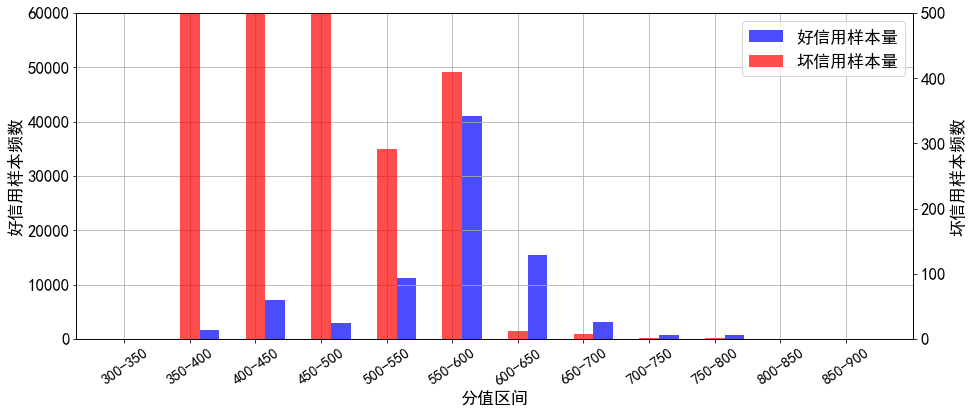

观察不同分数段中，好坏信用样本的概率密度分布：


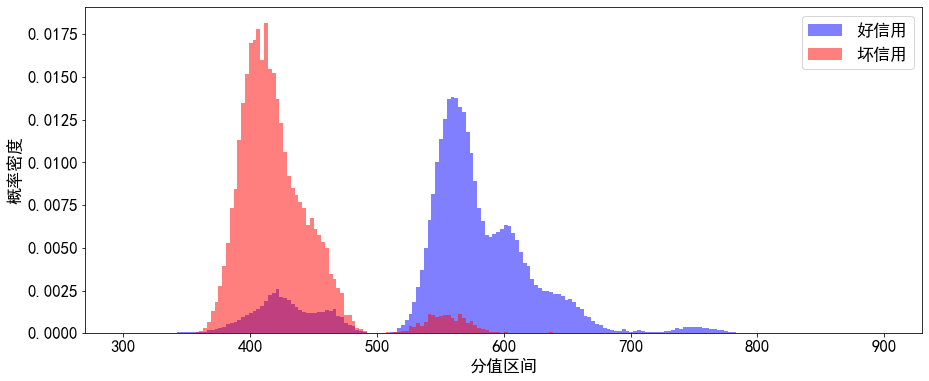

In [90]:
score_all = df_all_score.loc[:,['score','target']]
target_0_score = score_all.loc[score_all['target']==0]
target_1_score = score_all.loc[score_all['target']==1]


print('观察不同分数段中，好坏信用样本频数分布:\n好样本采用左侧纵轴刻度，坏样本采用右侧纵轴刻度')

bar_width = 0.3
fig, ax1 = plt.subplots(figsize=(15,6))
plt.bar(np.arange(0,12)+ bar_width,df_result.iloc[:,0],bar_width,alpha=0.7,color='blue', label='好信用样本量') 
ax1.set_ylabel('好信用样本频数',fontsize=17)
ax1.set_ylim([0,60000])
plt.grid(True)
plt.xlabel('分值区间',fontsize=17)
plt.xticks(np.arange(0,12),index_range,rotation=35,fontsize=15)
plt.yticks(fontsize=17)

# 共享横轴，双纵轴
ax2 = ax1.twinx()
ax2.bar(np.arange(0,12),df_result.iloc[:,1],bar_width,alpha=0.7,color='red', label='坏信用样本量')
ax2.set_ylabel('坏信用样本频数',fontsize=17)
ax2.set_ylim([0,500])
plt.yticks(fontsize=17)
plt.xlabel('分值区间',fontsize=17)

# 合并图例
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc='upper right',fontsize=17)
plt.show()


print('观察不同分数段中，好坏信用样本的概率密度分布：')
plt.figure(figsize=(15,6))
plt.hist(target_0_score.iloc[:,0],bins=200,alpha=0.5,label='好信用',
         color='blue',range=(300,900),density=True,rwidth=0.3,histtype='stepfilled')
plt.hist(target_1_score.iloc[:,0],bins=200,alpha=0.5,label='坏信用',
         color='red',range=(300,900),density=True,rwidth=0.3,histtype='stepfilled')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('分值区间',fontsize=17)
plt.ylabel('概率密度',fontsize=17)
plt.legend(fontsize=17)  
plt.show()

